# High-degree numerical differentiation of generating functions

Generating functions represent entire probability distributions as a single function, which can then ba manipulated in various ways to perform actions on the underlying probabilities. One important manipulation involves differentiating the generating function to extract coefficients from it. This use of differentiation is entirely "formal", in the sense that it's being used as a mechanism for accessing elements of a series rather than as anything actually to do with a rate of change.

Performing differentiation in a computer usually relies on numerical techniques, which turn out to be delicate when applied to the degree that we need them. More advanced numerical differentiation solves this problem and lets us perform the necessary calculations robustly.

It's worth noting that this technique -- Cauchy's formula -- has nothing to do with generating functions *per se*, and can be used in any setting that needs high-degree numerical differentiation of a function. It deserves to be better-known.

## Context

To recap, a probability generating function is a formal power series representing a discrete probability distribution, where each term of the series specifies the probability of the random variable taking a given value. The most common example is the node degree distribution generated by:

$$
G_0(x) = \sum_k p_k \, x^k
$$

where $p_k$ is the probability that a node chosen at random has degree $k$. The $x^k$ term is simply a "binder" that associates the coefficient with the value to which it refers.

There are two main ways to create such a generating function. In the first case (the *discrete* case) we know all the $p_k$ and simply chain them together with their "binders". In the second (*continuous*) case we have an expression for the series itself, for example the Poisson-distributed degree distribution of an ER network is generated by

$$
G_0(x) = e^{\langle k \rangle (x - 1)}
$$

One common operation to perform on this kind of distribution would be to extract the coefficient of a specific degree: what is the probability of choosing a node with degree 4, for example? This is by definition the coefficient of the term in $x^4$. In the discrete case we can simply read-off the appropriate coefficient; in the continuous case we cany differentiate $G_0(x)$ four times, normalise to get rid of the multiplicative factors introduced by differentiation, and then evaluate at $0$:

$$
p_4 = \frac{1}{4!} \bigg( \frac{d}{dx} \bigg)^4 G_0(x) \, \bigg|_{x = 0}
$$

This method of differentiation works for *any* generating function, including those that have no closed-form solution, which suggests that we need to be able to perform the operation numerically {cite}`ArbitraryDegreeDistributions`. 

## Numerical differentiation using `scipy`

There are lots of software solutions for numerical differentiation. In Python, the `scipy` library includes a function that's suitable for computing fairly low-degree derivatives.

To explore this approach, we'll need to compare the calculations against real networks. Let's define a function the extracts the degree histogram of a network, the number of nodes of each degree.

In [11]:
import math
import cmath
import numpy
import networkx
import scipy.misc
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [4]:
def nk_g(g):
    '''Given a network g, return a function that returns the number of
    nodes of a particular degree.
    
    :param g: a network
    :returns: a function from degree to number of nodes'''
    degrees = dict()
    for (_, k) in g.degree:
        if k in degrees:
            degrees[k] += 1
        else:
            degrees[k] = 1
    
    def nk(k):
        '''Return the number of nodes with degree k.
        
        :param k: the degree
        :returns: the number of nodes of this degree
        '''
        if k in degrees:
            return degrees[k]
        else:
            return 0
        
    return nk

We can use this function to create the more familiar function that gives us the probability $p_k$ that a node chosen at random will have degree $k$.

In [5]:
def pk_g(g):
    '''Given a network, return a function that gives the fraction of
    nodes with a given degree. This is also the probability that a
    node chosen from the network at random will have degree k.
    
    :param g: a network
    :returns: a function from degree to fraction'''
    nk = nk_g(g)
    
    def pk(k):
        '''Return the fraction of nodes of degree k.
        
        :param k: the degree
        :returns: the fraction of nodes with degree k'''
        return nk(k) / g.order()
    
    return pk

This function constructs $p_k$ given an empirical network: it counts the node degrees that actually exist. But we know that the degree distribution of an ER network has a closed-form expression: tthe probability of encountering a node of degree $k$ is given by $p_k = \frac{1}{\langle k \rangle !} \langle k \rangle^k e^{-\langle k \rangle}$, which we can code directly. 

In [6]:
def pk_ER(kmean):
    '''Return a function that computes p_k for a given k on an ER network.
    
    :param kmean: the mean degree of the network
    :returns: a function from degree to probability'''
    
    def pk(k):
        '''Return the probability of choosing a node of degree k.
        
        :param k: the degree
        :returnsd: the probability of picking a node of degree k'''
        return (math.pow(kmean, k) * math.exp(-kmean)) / math.factorial(k)
    
    return pk

```{note}
    We're making use of higher-order functions to simplify the
    code later on. To get a function from degree to probability,
    we create a constructor function that takes all the necessary
    parameters and then hides them from later code. This means
    we can create a probability function for an explicit network,
    an ER network, or any other sort of network, and use it uniformly
    without having to carry the parameters that were used to create it
    into the later code. This is a useful tool for code re-use.
```

We now have two functions for extracting the degree distribution: one that extracts it empirically from a network, and one that constructs the distribution of an ER network theoretically. These two functions should coincide, which we can check.

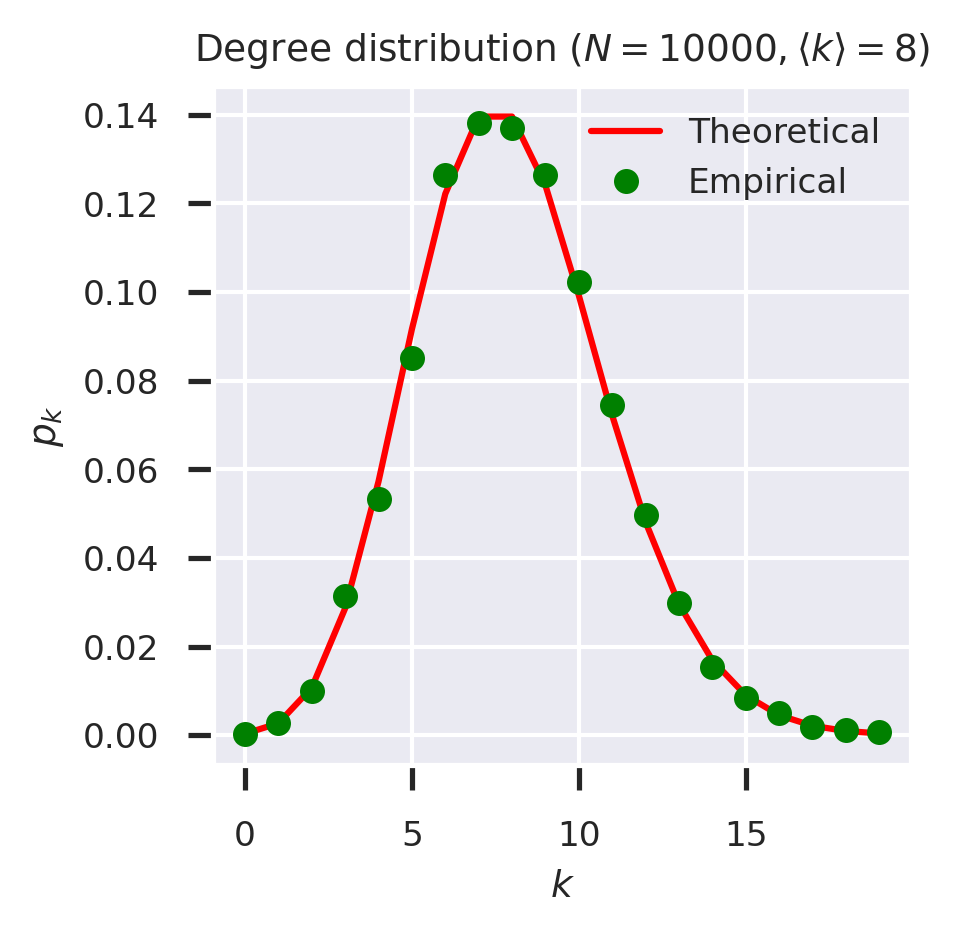

In [36]:
# network parameters
N = int(1e4)
kmean = 8

# create a random network with this topology
g = networkx.fast_gnp_random_graph(N, kmean / N)

fig = plt.figure(figsize=(3,3))

# theoretical values
ks = list(range(20))
theoretical = list(map(pk_ER(kmean), ks))

# empirical values
pk = pk_g(g)
empirical = list(map(pk, ks))

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks, empirical, 'go', label='Empirical')

plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($N = {N}, \\langle k \\rangle = {kmean}$)')

plt.show()

So far so good. We can also encapsulate the degree distribution as a generating function as defined above.

In [37]:
def G0_ER(kmean):
    '''Return the degree generating function for an ER network with mean degree kmean.
    
    :param kmean: the mean degree
    :returns: the generating function'''
    
    def G0(x):
        return cmath.exp(kmean * (x - 1))
    
    return G0

(You might have noticed that we used the `cmath` package to get exponentiation that includes complex numbers. The reason for this will become clear later.) The theory says that we can extract the $p_k$ values by repeated differentiation of this function, and we can use `scipy` to find the derivative of the appropriate order.

In [40]:
def pk_scipy(gf):
    '''Construct a function to extract the probability of finding a node
    with given degree by numerically differentiating the degree generating
    function using `scipy`.
    
    :param gf: the generating function
    :returns: the degree probability function'''
    
    # we need the real part of the generating funcxtion
    def gf_real(x):
        return gf(x).real
    
    def pk(k):
        return scipy.misc.derivative(gf_real, 0.0, n=k,
                                     dx=1e-2, order=k + 1 + (0 if k % 2 == 0 else 1)) / math.factorial(k)
    
    return pk

If we now plot the theoretical values against the results extracted from the generating function, they should again coincide.

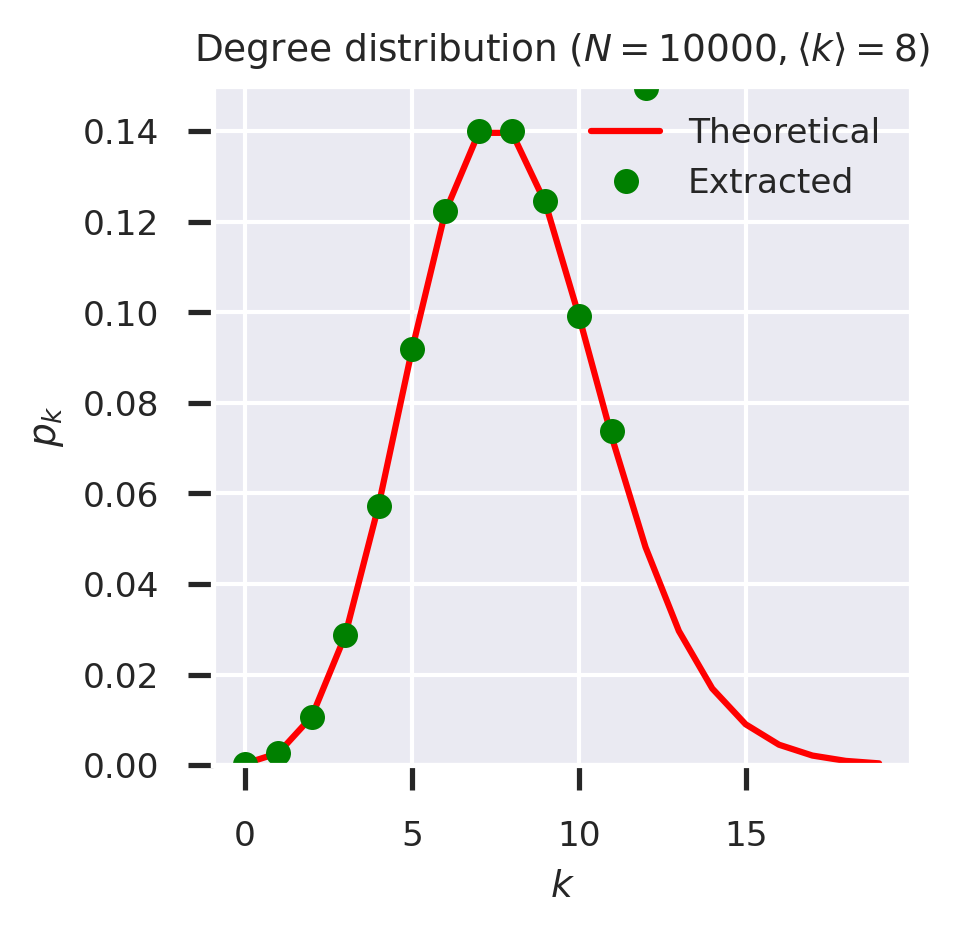

In [96]:
fig = plt.figure(figsize=(3,3))

# theoretical values
ks = list(range(20))
theoretical = list(map(pk_ER(kmean), ks))

# extracted values
pk = pk_scipy(G0_ER(kmean))
extracted = list(map(pk, ks))

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks, extracted, 'go', label='Extracted')

plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.ylim([0, 0.15])
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($N = {N}, \\langle k \\rangle = {kmean}$)')

plt.show()

It was going well up to about $k=12$, but then something went seriously wrong: the extracted values don't match. We can see this even more clearly if we try the same technique against a powerlaw-with-cutoff network.

In [75]:
def pk_PLC(exponent, cutoff):
    '''Return a function that computes p_k for a powerlaw network
    with the given exponent and cutoff.
    
    :param exponent: the exponent of the distribution
    :param cutoff: the cutoff
    :returns: a function from degree to probability'''
    
    # the normalising constant, which will be a real number
    # despite the possibility of polylog being complex
    C = complex(1 / mpmath.polylog(exponent, math.exp(-1 / cutoff))).real
    
    def pk(k):
        '''Return the probability of choosing a node of degree k >= 1.
        
        :param k: the degree
        :returns: the probability of picking a node of degree k'''
        return C * math.pow(k, -exponent) * math.exp(-k / cutoff)
    
    return pk

def G0_PLC(exponent, cutoff):
    '''Return the generating function for a powerlaw distribution with the
    given exponent and cutoff.
    
    :param exponent: the exponent
    :param cutoff: the cutoff
    :returns: the generating function'''
    
    def G0(x):
        return mpmath.polylog(exponent, x * math.exp(-1 / cutoff)) / mpmath.polylog(exponent, math.exp(-1 / cutoff))
    
    return G0

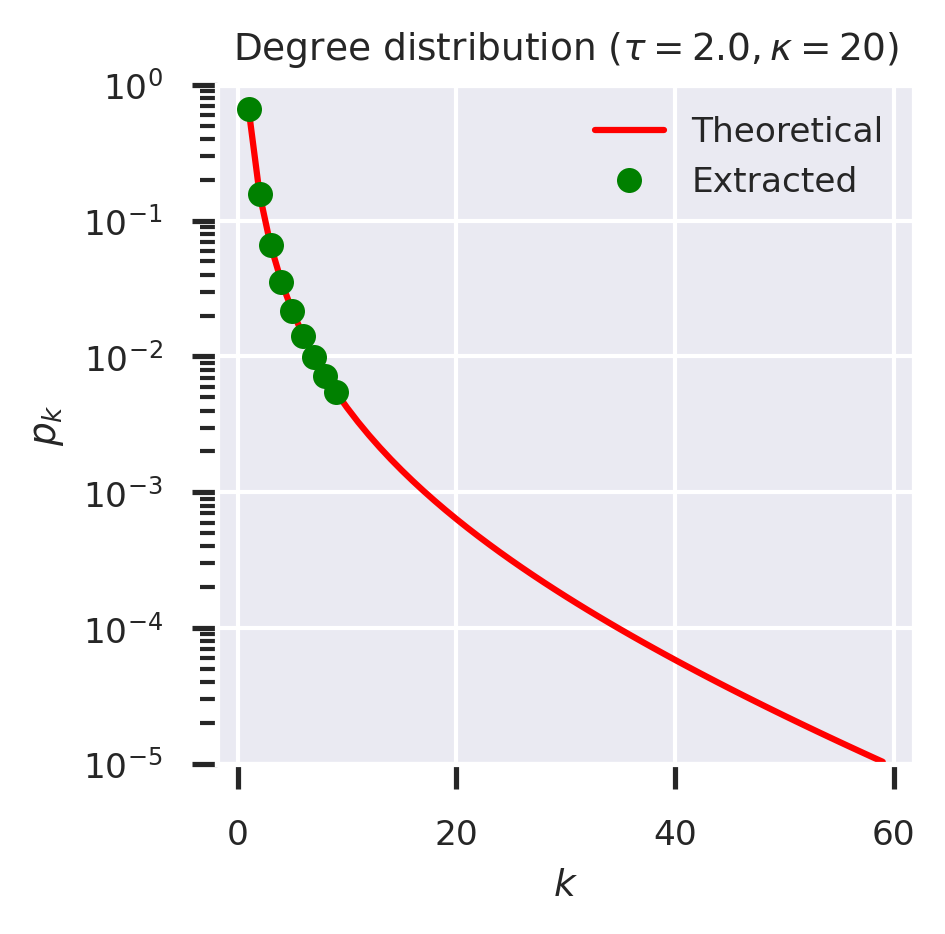

In [85]:
# PLC network parameters
exponent = 2.0
cutoff = 20

fig = plt.figure(figsize=(3,3))

# theoretical values
ks = list(range(1, 60))
theoretical = list(map(pk_PLC(exponent, cutoff), ks))

# extracted values
pk = pk_scipy(G0_PLC(exponent, cutoff))
extracted = list(map(pk, ks))

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks, extracted, 'go', label='Extracted')

plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.yscale('log')
plt.ylim([1e-5, 1])
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($\\tau = {exponent}, \kappa = {cutoff}$)')

plt.show()

Again, we lose results at about $k = 10$.

What's happening? The problem is the numerical instability of the approach used for numerical differentiation, which starts to break down for high-order derivatives. Since we might have networks with degree significantly greater than 10, this approach to manipulating generating functions isn't going to be practical. 

## Numerical differentiation using Cauchy's formula

There is, however, another approach that involves significantly more sophisticated mathematics. This is suggested in a throwaway comment in {cite}`ArbitraryDegreeDistributions`, repeated in {cite}`NewmanEpidemics`, about using [Cauchy's integral formula](https://en.wikipedia.org/wiki/Cauchy's_integral_formula)

$$
f^{(n)}(z) = \frac{n!}{2 \pi i} \oint_C \frac{f(w)}{(w - z)^{n + 1}} \, dw
$$

This approach may give us the tools we need, and so may be worth understanding despite the fearsome-looking mathematics.

The general approach is simple to state. To compute the $n$'th derivative of a real-valued function $f$, we make an excursion into the complex plane, choosing a closed contour $C$ and computing a path integral around this path. Under certain conditions to do with the function having no poles within $C$, this approach computes high-order derivatives without succumbing to numerical instability.

We need to turn the formula into something executable. We will do this in stages.

### Stage 1: Defining the contour

We first need the contour $C$. By "contour" we simply mean a closed loop in the complex plane that encloses the poiint at which we want to perform the differentiation. The simplest appropriate contour is therefore a circle around the point in the complex plane where we want to evaluate the derivative.

We can describe a circle around the origin as a parameterised curve $w = r e^{i\theta}$ where $r$ is the radius of the circle and $0 < \theta < 2\pi$. The circle around a point $z$ is simply this circle shifted to that point, so $w = r e^{i\theta} + z$.

### Step 2: Integrating round the contour

We now need to integrae around this countour. We change the path integral around $C$, $\oint_C$, into an ordinary integral on the range of $\theta$, $\int_0^{2\pi}$, changing the variable of integration accordingly. Essentially this changes the arbitrary contour into a circle that we "walk around" by moving through $2 \pi$ radians. To change variable we perform

$$
\oint_C f(w) \, dw = \int_l^h f(\theta) \frac{dw}{d\theta} d\theta 
$$

Taking $w$ from above, $\frac{dw}{d\theta} = r i e^{i\theta}$, so

$$
\oint_C \frac{f(w)}{(w - z)^{n + 1}} \, dw
    = \int_0^{2 \pi} \frac{f(r e^{i \theta} + z)}{(r e^{i \theta} + z - z)^{n + 1}} \, r i e^{i \theta} \, d\theta
    = \int_0^{2 \pi} \frac{f(r e^{i \theta} + z)}{(r e^{i \theta})^n} \, i \, d\theta
$$

and so

$$
f^{(n)}(z) = \frac{n!}{2 \pi} \int_0^{2 \pi} \frac{f(r e^{i \theta} + z)}{(r e^{i \theta})^n} \, d\theta
$$

with the complex unit $i$ within the integrand being taken out to cancel the $i$ in the constant factor.

### Step 3: Simplifying

We could code-up this integral directly, but we can simplify slightly more by observing that we can make $\theta = 2 \pi x$ and let $0 < x < 1$. Changing variable of integration again, we have $\frac{d\theta}{dx} = 2 \pi$ and so

$$
f^{(n)}(z) = \frac{n!}{2 \pi} \int_0^{2 \pi} \frac{f(r e^{i \theta} + z)}{(r e^{i \theta})^n} \, d\theta
           = \frac{n!}{2 \pi} \int_0^1 \frac{f(r e^{2 \pi x i} + z)}{(r e^{2 \pi x i})^n} \, 2 \pi \, dx 
           = n! \int_0^1 \frac{f(r e^{2 \pi x i} + z)}{(r e^{2 \pi x i})^n} \, dx
$$

That gets rid of the constant $\frac{1}{2 \pi}$ factor.

### Step 4: Discretising the integral

The expression we now have is an integral on a continuous range $[0, 1]$. To evaluate this integral numrically we need to discretise it so that we compute the integrand at specific points. To do this we create the Riemann sum of the integral where we evaluate it at $m$ equally-spaced points on the range, which of course correspond to $m$ equally-spaced points around the circular contour in the complex plane. 

Let $\delta x = \frac{1}{m}$ (where the numerator comes from knowing we have a unit interval). The for any function $h(z)$ we have that

$$
\int_0^1 h(x) \, dx \approx \sum_{j = 1}^m h(x + j \delta x) \, \delta x
$$

where the approximation becomes exact as $m \rightarrow \infty$. We can simplify this expression to make it easier to evaluate by observing that

$$
\sum_{j = 1}^m h(x + j \delta x) \, \delta x
= \sum_{j = 1}^m h(x + j \delta x) \, \frac{1}{m}
= \frac{1}{m} \sum_{j = 1}^m h(x + j \delta x)
= \bigg\langle h(x + j \delta x) \bigg\rangle_{j = 1}^m
$$

where $\langle \cdot \rangle_a^b$ denotes the average of a function in the range $[a, b]$. So if we take a small step size we can take the average of the integrand for values taken at each step around the unit interval to approximate the integral. 

Substituting back into our original problem, we arrive at

$$
f^{(n)}(z) \approx n! \bigg\langle \frac{f(r e^{2 \pi j \delta x i} + z)}{(r e^{2 \pi j \delta x i})^n} \bigg\rangle_{j = 0}^m
$$

The smaller the step size the more accurate the approximation, but the more calculations we need to do.

### Coding in Python

We can now code this expression directly in Python. We first construct the array of points along the unit interval. We then compute the mean of the integrand at these points to get the approximate integral, and multiply the result by $n!$. 

In [93]:
def differentiate(f, z, n=1, r=1.0, dx=1e-2):
    '''Compute the n'th derivative of f at z using a Cauchy contour
    integral around a circle of radius r in the complex plane.

    :param f: function of one (complex) variable
    :param z: point at which to find the derivative
    :param n: order of derivative (defaults to 1)
    :param r: radius of contour (defaults to 1.0)
    :param dx: step size (defaults to 1e-2)'''

    # make sure the function vectorises
    if not isinstance(f, numpy.vectorize):
        f = numpy.vectorize(f)

    # compute the array of points at which to compute the integrand
    x = r * numpy.exp(2j * numpy.pi * numpy.arange(0, 1, dx))
    
    return math.factorial(n) * numpy.mean(f(z + x) / x**n)

(We use `numpy`'s vectorised functions to let us apply a function pointwise to an array, and `numpy`'s exponentiation function to handle complex exponentials. We also fix some defaults, such as using a unit circle of radius 1 as the contour and a step size that gives us 100 points to compute. Finally, remember that in Python the complex unit is represenetd by `j`.)

Now we can check whether this approach lets us extract the higher-order derivatives we need. The values of $p_k$ extracted in theory for the network, and the values extracted by differentiating the generating function, should coincide.

In [88]:
def pk_cauchy(gf):
    '''Construct a function to extract the probability of finding a node
    with given degree by numerically differentiating the degree generating
    function using Cauchy's formula.
    
    :param gf: the generating function
    :returns: the degree probability function'''
    
    def pk(k):
        return complex(differentiate(gf, 0, k)).real / math.factorial(k)
        
    return pk

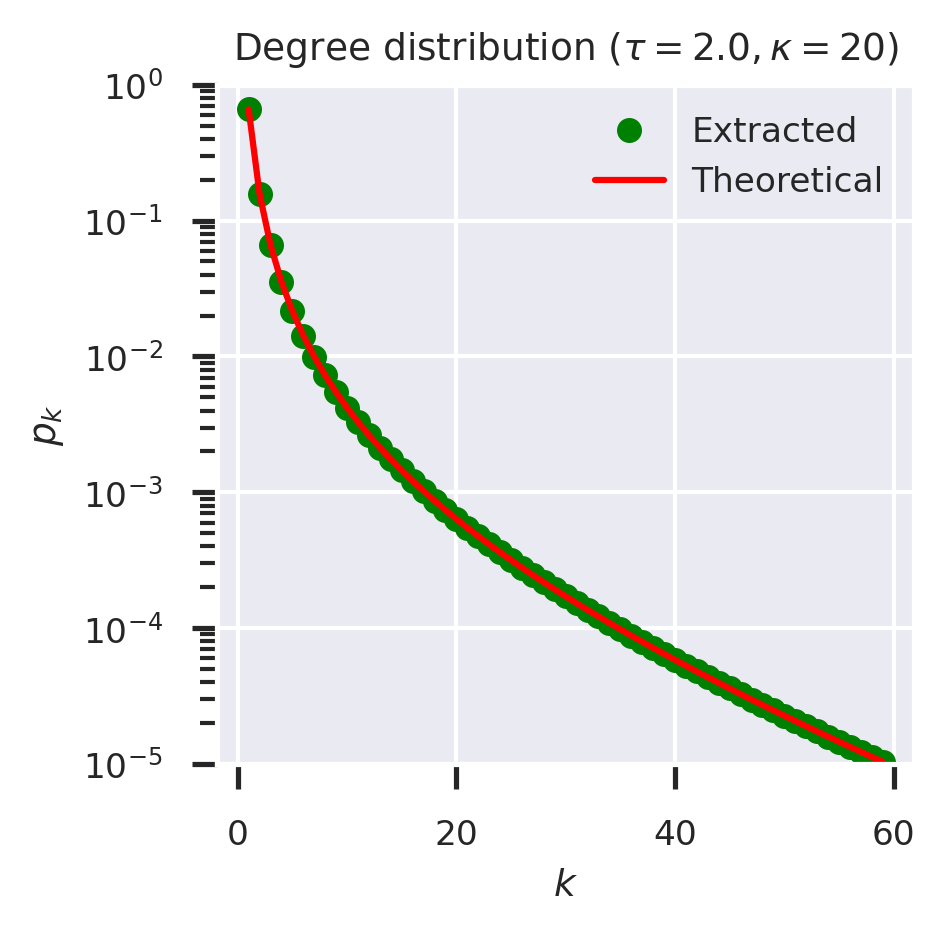

In [94]:
# PLC network parameters
exponent = 2.0
cutoff = 20

fig = plt.figure(figsize=(3,3))

# theoretical values
ks = list(range(1, 60))
theoretical = list(map(pk_PLC(exponent, cutoff), ks))

# extracted values
pk = pk_cauchy(G0_PLC(exponent, cutoff))
extracted = list(map(pk, ks))

plt.plot(ks, extracted, 'go', label='Extracted')
plt.plot(ks, theoretical, 'r-', label='Theoretical')

plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.yscale('log')
plt.ylim([1e-5, 1])
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($\\tau = {exponent}, \kappa = {cutoff}$)')

plt.show()

*Much* better! Using the Cauchy formula to compute the derivatives allows us to go up to far higher orders than using more direct methods. The mathematics looks formidable, but can be translated step-by-step into something that can easily be coded directly. The only thing that still requires care is to ensure that the generating function is coded to work with complex numbers so that it can be evaluated around the countour in the complex plane. This can generally be accomplished transparently by using either `numpy` or `cmath` functions for exponentiation and so on.

It's worth noting that, although we're using this approach to manipulate generating functions, therethis technique works for *any* high-order differentiation problem. Conversely, even though we're using differentiation "formally", as a technique to manipulate a series, it is still really differentiation, and so can be tackled using all the available calculus techniques.